[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 1401
    # variables        = 3
    chi-square         = 1681.67825
    reduced chi-square = 1.20291721
    Akaike info crit   = 261.830989
    Bayesian info crit = 277.565814
[[Variables]]
    scale:       1.01574652 +/- 8.8790e-04 (0.09%) (init = 1)
    KG:          0.009908073 (fixed)
    KL:          0 (fixed)
    deltaG:      0 (fixed)
    deltaL:      0 (fixed)
    ADP_Li1:     0.56237169 +/- 0.00897209 (1.60%) (init = 0.6)
    ADP_F1:      0.28283431 +/- 0.00252364 (0.89%) (init = 0.3)
    delta1_Li1:  0 (fixed)
    delta1_F1:   0 (fixed)
    lattice_a:   4 (fixed)
    lattice_b:   4 (fixed)
    lattice_c:   4 (fixed)
    lattice_al:  90 (fixed)
    lattice_be:  90 (fixed)
    lattice_ga:  90 (fixed)
    spher_rad:   100000 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale, ADP_F1)  = 0.533
    C(scale, ADP_Li1) = 0.355
Time to refine model: 10.900052

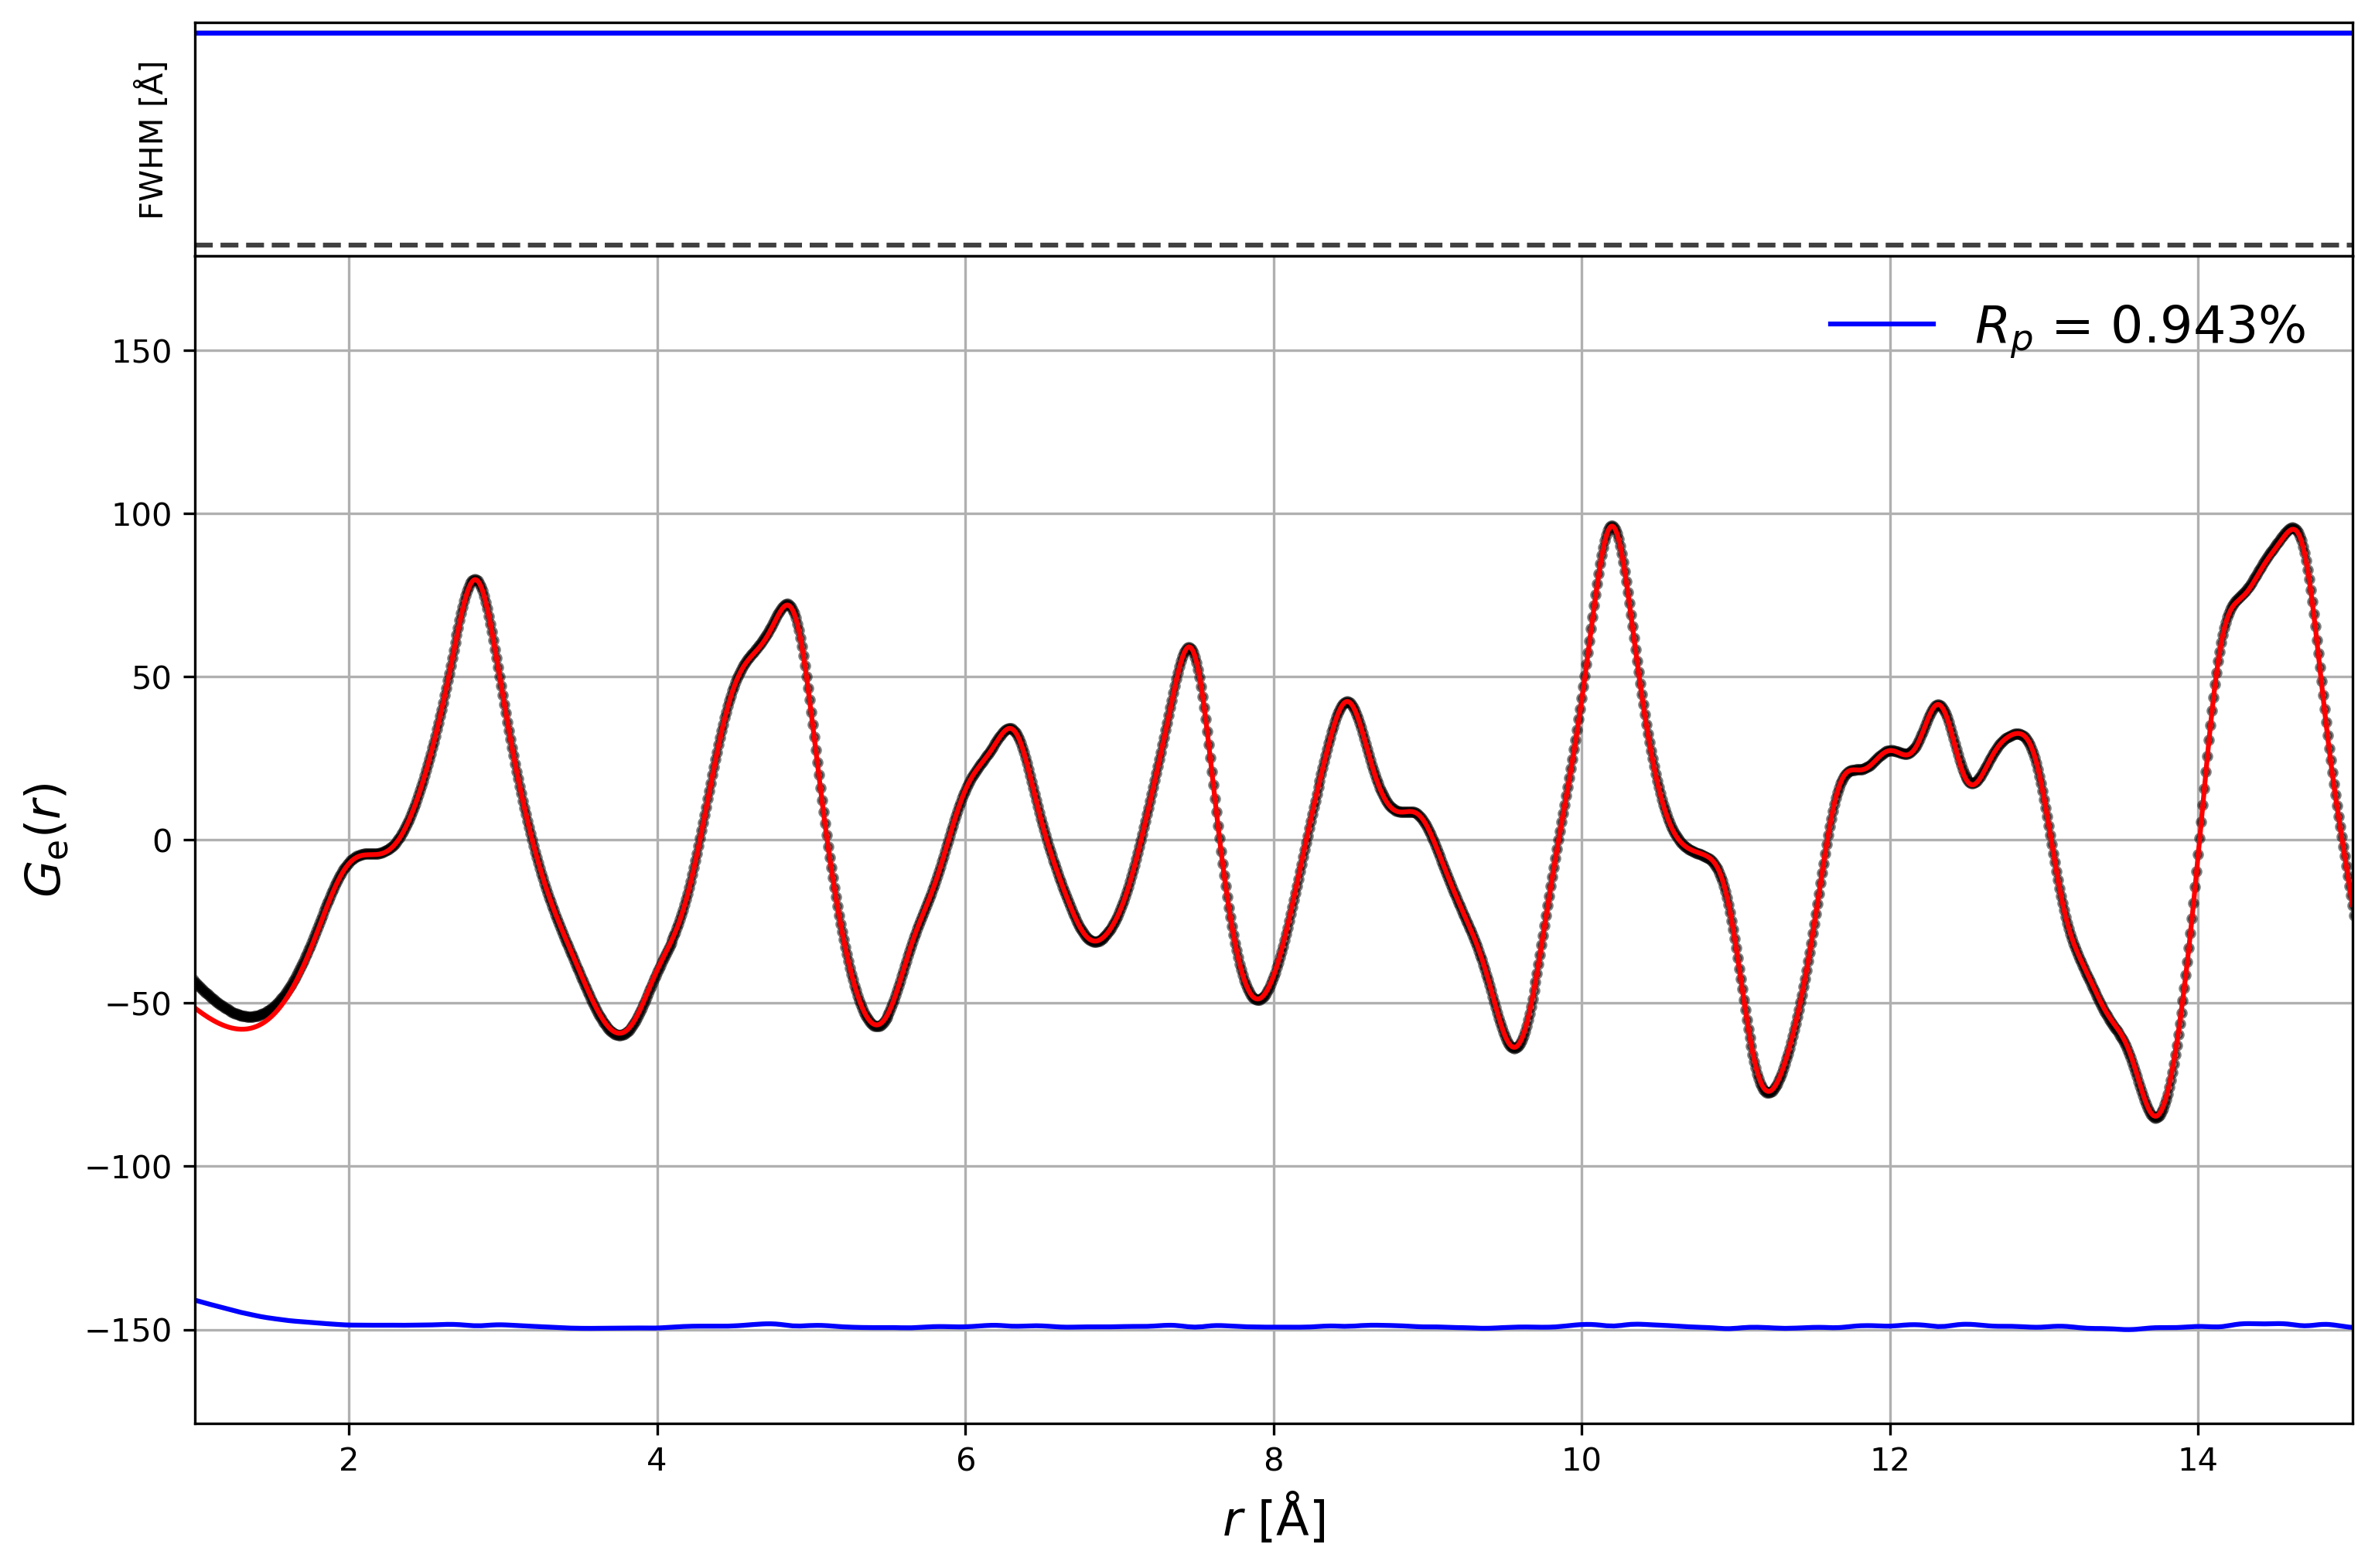

In [1]:
import os, time
import xraydb
from tqdm.auto import tqdm
from gemmi import cif, read_small_structure
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import ifft
from scipy.interpolate import interp1d
from scipy.signal import oaconvolve
from diffpy.pdfgetx.cromermann import fxrayatq
from diffpy.Structure import Structure, Lattice
from diffpy.Structure import Atom as DiffpyAtom
from diffpy.Structure.spacegroups import GetSpaceGroup
from diffpy.structure.symmetryutilities import expandPosition
from diffpy.srreal.bondcalculator import BondCalculator
from lmfit import Parameters, Minimizer, report_fit, fit_report


class Atom:
    def __init__(self, label='', element='', charge=0, Z=1, xyz=(0, 0, 0), ADP=0.25, occ=1, n=1, energy=None):
        self.label = label
        self.element = element
        self.charge = charge
        self.Z = Z
        self.xyz = xyz
        assert ADP >= 0, 'Negative thermal motion for atom '+label
        self.ADP = ADP
        self.occ = occ
        self.n = n
        self.energy = energy
        if charge > 0:
            self.ionlabel = element + str(charge) + '+'
            self.valence = '(+'+str(charge)+')'
        elif charge < 0:
            self.ionlabel = element + str(charge)[::-1]
            self.valence = '('+str(charge)+')'
        else:
            self.ionlabel = element
            self.valence = ''
        self.elec = Z - charge
        self.electronDensity()


    def electronDensity(self, extra='exponential'):
        # generate form factors
        qmax_bank = 75.0 # Waasmaier-Kirfel (limit q = 75 Å^-1)
        qmax_hypo = 500.0
        qstep_bank = 0.01
        rstep_hypo = np.pi/qmax_hypo

        q_bank = np.arange(0, qmax_bank+qstep_bank, qstep_bank)
        f_bank = np.array([fxrayatq(self.ionlabel, qi) for qi in q_bank])
        if self.energy:
            f_p = xraydb.f1_chantler(self.element, self.energy*1e3)
            f_pp = xraydb.f2_chantler(self.element, self.energy*1e3)
        else:
            f_p = 0
            f_pp = 0
        f_bank += f_p
        self.elec += f_p
        
        # extrapolation to qmax_hypo, and cast as even function
        q_hypo = np.arange(0, qmax_hypo+qstep_bank, qstep_bank)
        f = np.zeros(2*len(q_hypo)-1)
        
        if extra == 'linear':
            a = -f_bank[-1]/(qmax_hypo-qmax_bank)
            b = -a*qmax_hypo
            f_extra = [a*qi + b for qi in q_hypo]
        else:
            f_gradient = (f_bank[-2]-f_bank[-1])/qstep_bank
            k = f_gradient/f_bank[-1]
            A = -(f_bank[-1])/np.exp(-k*qmax_bank)
            f_extra = -A*np.exp(-k*q_hypo)
        
        f[0:len(f_bank)] = f_bank
        f[len(f_bank):len(f_extra)] = f_extra[len(f_bank):len(f_extra)]
        f[len(f_extra):2*len(f_extra)-len(f_bank)] = f_extra[len(f_bank):len(f_extra)][::-1]
        f[2*len(f_extra)-len(f_bank):] = f_bank[-2::-1]

        # calcuate electron density as Fourier transformation
        rho = 1/rstep_hypo*np.real(ifft(f))
        mid = len(rho)//2
        rho = np.roll(rho, mid)
        
        # re-normalize to nominal number of electrons
        self.rrho = np.arange(-len(f)//2+1, len(f)//2+1)*rstep_hypo
        norm_factor = self.elec/np.trapz(rho, self.rrho)
        self.rho = rho*norm_factor


class Pair:
    def __init__(self,
                 label='',
                 atom1:Atom=None,
                 atom2:Atom=None,
                 rhopeakextent=5):
        self.label = label
        self.atom1 = atom1
        self.atom2 = atom2

        rrho, rho1 = atom1.rrho, atom1.rho
        rrho, rho2 = atom2.rrho, atom2.rho
        rrho_step = rrho[1] - rrho[0]
        rho_conv = rrho_step*oaconvolve(rho1, rho2, 'same')
        rho_peak_filter = (rrho > -rhopeakextent-1e-8) & (rrho < rhopeakextent+1e-8)
        self.rrhoconv = rrho[rho_peak_filter]
        self.rhoconv = rho_conv[rho_peak_filter]

        self.PDP = np.sqrt((atom1.ADP + atom2.ADP)/(8*np.pi**2))
    
    def setCounts(self, counts):
        self.counts = counts


class EDFModel:
    def __init__(self, name='', data='', cif='',
                 rmin=0, rmax=30,
                 rpeak_extent=5,
                 qmax=None,
                 energy=None,
                 nyquist=False,
                 silent=False):
        self.modelName = name
        self.dataFname = data
        self.qmax = qmax
        self.energy = energy
        self.cpus = os.cpu_count()
        self.silentFlag = silent
        self.nyquistFlag = nyquist
        if self.nyquistFlag:
            assert qmax is not None, 'please provide qmax for Nyquist interval'
        assert rmin < rmax, 'rmin greater than rmax'
        if data:
            self.rmin_user = rmin
            self.rmax_user = rmax            
            self.loadData()
            self.rmin = self.rdata[((self.rdata>self.rmin_user-1e-8) & (self.rdata<self.rmax_user+1e-8))][0]  # change rmin to corresponding value from data
            self.rmax = self.rdata[((self.rdata>self.rmin_user-1e-8) & (self.rdata<self.rmax_user+1e-8))][-1] # change rmax to corresponding value from data
            self.data_filter = ((self.rdata>self.rmin-1e-8) & (self.rdata<self.rmax+1e-8))
        else:
            if self.nyquistFlag:
                self.rstep = np.around(np.pi/self.qmax, decimals=6)
            else:
                self.rstep = 0.05
            self.rmin = rmin
            self.rmax = rmax

        self.rpeak_extent = (rpeak_extent // self.rstep + 1)*self.rstep # convert to multiple of rstep
        rrange = self.rmax - self.rmin
        assert self.rpeak_extent < rrange/2, f"Model: \"please select smaller value for rpeak_extent (less than half of r-range, {rrange:.2f})\""
        self.rmodel = np.arange(self.rmin-self.rpeak_extent, self.rmax+2*self.rpeak_extent+1e-8, self.rstep)
        self.model_filter = ((self.rmodel>self.rmin-1e-8)&(self.rmodel<self.rmax+1e-8))        

        self.refineCell = False
        if cif: self.loadCIF(cif)


    def loadData(self):
        self.data = np.genfromtxt(self.dataFname)
        self.rdata = self.data[:, 0]
        self.Gr_data = self.data[:, 1]
        self.rmin_data = self.rdata[0]
        self.rmax_data = self.rdata[-1]
        rstep_ini = np.around(self.rdata[1] - self.rdata[0], decimals=6)
        rstep_fin = np.around(self.rdata[1] - self.rdata[0], decimals=6)
        assert rstep_ini == rstep_fin, 'loadData: \"please ensure equidistant r-grid in PDF\"'
        self.rstep = self.rdata[1] - self.rdata[0]
        if self.nyquistFlag:
            self.rstep = np.around(np.pi/self.qmax, decimals=6)
            interp_func = interp1d(self.rdata, self.Gr_data, kind='cubic')
            self.rdata = np.arange(self.rmin_data, self.rmax_data, self.rstep)
            self.Gr_data = interp_func(self.rdata)
        else:
            self.rstep = self.rdata[1] - self.rdata[0]
        if not self.silentFlag:
            if self.rmin_user < self.rmin_data:
                print(f'loadData: \"Setting rmin to experimental limit ({self.rmin_data:.2f})\"')
                self.rmin = self.rmin_data
            if self.rmax_user > self.rmax_data:
                print(f'loadData: \"Setting rmax to experimental limit ({self.rmax_data:.2f})\"')
                self.rmax = self.rmax_data


    def loadCIF(self, cifFname):
        # load informaiton from cif
        cifstructure = read_small_structure(cifFname)           # gemmi parser
        self.sgNumber = cifstructure.find_spacegroup().number   # gemmi parser
        self.sg = GetSpaceGroup(self.sgNumber)                  # diffpy
        self.crystal_system = self.sg.crystal_system            # diffpy
        
        # load atoms in asymmetric unit
        atoms = {}
        site_multiplicity = list(map(int, cif.read(cifFname).sole_block().find_loop('_atom_site_symmetry_multiplicity')))
        for i, atomincif in enumerate(cifstructure.sites):
            atoms[atomincif.label] = Atom(label=atomincif.label,
                                          element=atomincif.element.name,
                                          charge=atomincif.charge,
                                          Z=atomincif.element.atomic_number,
                                          xyz=tuple(atomincif.fract),
                                          ADP=atomincif.u_iso,
                                          occ=atomincif.occ,
                                          n=site_multiplicity[i],
                                          energy=self.energy)
        self.atoms = atoms
        self.total_atoms = np.sum([atom.n for atom in self.atoms.values()])
        self.total_elec = np.sum([atom.elec*atom.n for atom in self.atoms.values()])
        self.mean_elec = self.total_elec/self.total_atoms

        # generate unique pair types
        pairtypes = set()
        for atom_i in self.atoms.values():
            for atom_j in self.atoms.values():
                pairtypes.add(tuple(sorted([atom_i.label, atom_j.label])))
        pairs = {}
        for atom1, atom2 in pairtypes:
            pairlabel = self.atoms[atom1].label+'_'+self.atoms[atom2].label
            pairs[pairlabel] = Pair(label=pairlabel,
                                    atom1=self.atoms[atom1],
                                    atom2=self.atoms[atom2],
                                    rhopeakextent=self.rpeak_extent+self.rstep)
        self.pairs = pairs

        # generate structure
        structure = Structure()
        cifcell = cifstructure.cell
        lattice = Lattice(a=cifcell.a,
                          b=cifcell.b,
                          c=cifcell.c,
                          alpha=cifcell.alpha,
                          beta=cifcell.beta,
                          gamma=cifcell.gamma)
        structure.placeInLattice(lattice)
        for atom in self.atoms.values():
            symmeqpositions = expandPosition(self.sg, atom.xyz)
            for pos in symmeqpositions[0]:
                structure.addNewAtom(DiffpyAtom(atom.label, pos))
        self.structure = structure
        self.volume = self.structure.lattice.volume
        self.elec_density = self.total_elec/self.volume
        self.avg_atom_density = self.total_atoms/self.volume
        self.avg_elec_corr = self.elec_density*self.total_elec

        # calculate interatomic distances
        st = time.perf_counter()
        self.calculateInteratomDist()
        end = time.perf_counter()
        if not self.silentFlag:
            print(f"loadCif: \"Time to calculate bond distances: {end-st:.2f} s. (Total unique correlations: {self.correlations})\"")
        self.refineable_params = ['scale', 'KG', 'KL', 'deltaG', 'deltaL', 'spher_rad']
        self.refineable_params += ['lattice_a', 'lattice_b', 'lattice_c', 'lattice_al', 'lattice_be', 'lattice_ga']
        self.refineable_params += ['ADP_'+atom.label for atom in self.atoms.values()]
        self.refineable_params += ['delta1_'+atom.label for atom in self.atoms.values()]
        if not self.silentFlag:
            print(f"loadCif: \"Currently refinable parameters:")
            itemsprline = 7
            for i in range(len(self.refineable_params)//itemsprline + 1):
                if i+itemsprline < len(self.refineable_params) - 1:
                    print('   ', tuple(self.refineable_params[i*itemsprline:i*itemsprline+itemsprline]))
                else:
                    print('   ', tuple(self.refineable_params[i*itemsprline:]))


    def calculateInteratomDist(self):
        bc = BondCalculator(rmax=self.rmax+2*self.rpeak_extent+self.rstep)
        peaks = {}
        correlations = 0
        for label, pair in self.pairs.items():
            bc.setTypeMask(pair.atom1.label, pair.atom2.label, True, others=False)
            dists, npairs = np.unique(np.around(bc(self.structure), decimals=6), return_counts=True)
            peaks[label] = [dists, npairs]
            unique_pairs = len(dists)
            self.pairs[label].setCounts(unique_pairs)
            correlations += unique_pairs
        self.correlations = correlations
        self.peaks = peaks

    
    def updateStructure(self, lattice_param):
        lattice_a = lattice_param['a']
        lattice_b = lattice_param['b']
        lattice_c = lattice_param['c']
        lattice_al = lattice_param['al']
        lattice_be = lattice_param['be']
        lattice_ga = lattice_param['ga']
        if self.crystal_system == 'CUBIC':
            lattice_b, lattice_c = lattice_a, lattice_a
            lattice_al, lattice_be, lattice_ga = 90, 90, 90
        elif self.crystal_system == 'RHOMBOHEDRAL':
            lattice_b, lattice_c = lattice_a, lattice_a
        elif self.crystal_system == 'TETRAGONAL':
            lattice_b = lattice_a
            lattice_al, lattice_be, lattice_ga = 90, 90, 90
        elif self.crystal_system == 'ORTHORHOMBIC':
            lattice_al, lattice_be, lattice_ga = 90, 90, 90
        elif self.crystal_system == 'HEXAGONAL':
            lattice_b = lattice_a
            lattice_al, lattice_be = 90, 90
            lattice_ga = 120
        elif self.crystal_system == 'MONOCLINIC':
            lattice_al, lattice_ga = 90, 90
        lattice = Lattice(a=lattice_a,
                            b=lattice_b,
                            c=lattice_c,
                            alpha=lattice_al,
                            beta=lattice_be,
                            gamma=lattice_ga)
        structure = Structure()
        structure.placeInLattice(lattice)
        for atom in self.atoms.values():
            symmeqpositions = expandPosition(self.sg, atom.xyz)
            for pos in symmeqpositions[0]:
                structure.addNewAtom(DiffpyAtom(atom.label, pos))
        self.structure = structure
        self.volume = self.structure.lattice.volume
        self.elec_density = self.total_elec/self.volume
        self.avg_atom_density = self.total_atoms/self.volume
        self.avg_elec_corr = self.elec_density*self.total_elec
        self.calculateInteratomDist()


    def gauss(self, x, fwhm):
        norm_factor = 2/fwhm * np.sqrt(np.log(2)/np.pi)
        exponent = -4*np.log(2)/fwhm**2 * (x)**2
        return norm_factor*np.exp(exponent)


    def lorentz(self, x, fwhm):
        norm_factor = fwhm/(2*np.pi)
        lor = 1/(x**2 + (fwhm/2)**2)
        lor = lor/np.trapz(norm_factor*lor, x)
        return norm_factor*lor
   

    def EDF(self,
            scale,
            KG, KL,
            deltaG, deltaL,
            lattice_param,
            ADPs, delta1s,
            spher_rad):
        # recalculate peak positions if cell is refined
        if self.refineCell:
            self.updateStructure(lattice_param)

        Gr = np.zeros_like(self.rmodel)
        pool = mp.Pool()
        jobs = []
        cpus_pr_pair = (self.cpus - len(self.pairs) - 1)//len(self.pairs)
        for pairlabel, dist_counts in self.peaks.items():
            dists = np.array_split(dist_counts[0], cpus_pr_pair)
            counts = np.array_split(dist_counts[1], cpus_pr_pair)
            for i in np.arange(cpus_pr_pair):
                jobs.append(pool.apply_async(partialGr,
                                            args=(dists[i], counts[i],
                                            self.rmin, self.rmax, self.rpeak_extent, self.rmodel, self.rstep,
                                            self.pairs[pairlabel].rrhoconv, self.pairs[pairlabel].rhoconv,
                                            KG, KL,
                                            deltaG, deltaL,
                                            ADPs[self.pairs[pairlabel].atom1.label],
                                            ADPs[self.pairs[pairlabel].atom2.label],
                                            delta1s[self.pairs[pairlabel].atom1.label],
                                            delta1s[self.pairs[pairlabel].atom2.label])))
        pool.close()
        pool.join()
        Gr = sum((job.get() for job in jobs))

        # sinc function
        #r_qmax_sinc = np.arange(-self.rpeak_extent, self.rpeak_extent+1e-8, self.rstep)
        #qmax_sinc = np.sin(self.qmax*r_qmax_sinc)/r_qmax_sinc
        #qmax_sinc = qmax_sinc/np.trapz(qmax_sinc, r_qmax_sinc)
        #Gr = self.rstep*oaconvolve(Gr, qmax_sinc, mode='same')

        # slope
        Gr = Gr[self.model_filter]
        rfit = self.rmodel[self.model_filter]
        gauss_damp = np.exp(-0.5*(KG*rfit)**2/(8*np.log(2)))
        lor_damp = np.exp(-KL*rfit)
        slope = gauss_damp*lor_damp*4*np.pi*rfit*self.avg_elec_corr

        # size damping
        size_damp = np.zeros_like(rfit)
        size_filter = (rfit <= 2*spher_rad)
        size_damp[size_filter] = (1/4*(rfit[size_filter]/spher_rad)**3 - 3*rfit[size_filter]/spher_rad + 4)/4
        Gr = scale*(Gr - slope)*size_damp/self.total_atoms
        
        return Gr
        

    def plot(self, scale=0.1):
        scale = scale
        KG = 0.05
        KL = 0.000
        deltaG = 0.000
        deltaL = 0.000
        spher_rad = 50
        ADPs = {}
        delta1s = {}
        for atom in self.atoms.values():
            ADPs[atom.label] = 0.45/(8*np.pi**2)
            delta1s[atom.label] = 0.5
        
        lattice_param = {'a': self.structure.lattice.a,
                         'b': self.structure.lattice.b,
                         'c': self.structure.lattice.c,
                         'al': self.structure.lattice.alpha,
                         'be': self.structure.lattice.beta,
                         'ga': self.structure.lattice.gamma}

        Gr_model = self.EDF(scale,
                            KG, KL,
                            deltaG, deltaL,
                            lattice_param,
                            ADPs, delta1s,
                            spher_rad)

        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.plot(self.rdata, self.Gr_data, 'k.-',)
        ax.plot(self.rmodel[self.model_filter], Gr_model, 'r-')
        ax.set_xlim(self.rmin, self.rmax)
        ax.set_ylim(-np.max(self.Gr_data)*1.5, np.max(self.Gr_data)*1.5)


    def refine(self,
               report=False,
               save=False,
               param_dict={},
               initval_dict={},
               max_iter=20):
        # assess param_dict and initval_dict
        if len(param_dict) < 1:
            print(f"Refine: \"Please pass param_dict [dict(param: True/False)] and initval_dict [dict(param: val)] to refine\"")
            raise SystemExit
        assert len(param_dict) == len(initval_dict), f"Refine: \" Please ensure equal length of param_dict and initval_dict\""

        # cpus for multiprocessing
        if not self.silentFlag:
            if self.cpus > 1:
                print(f"Refine: \"Using {int(self.cpus)} cores for multiprocessing\"")

        # update structure with initial lattice parameters
        lattice_init = {'a': initval_dict['lattice_a'],
                        'b': initval_dict['lattice_b'],
                        'c': initval_dict['lattice_c'],
                        'al': initval_dict['lattice_al'],
                        'be': initval_dict['lattice_be'],
                        'ga': initval_dict['lattice_ga'],}
        self.updateStructure(lattice_init)

        # Repack user parameters to lmfit Parameters() object
        lmfitparameters = Parameters()
        for param in initval_dict.keys():
            if 'ADPs' in param:
                lmfitparameters.add(param,
                                    value=initval_dict[param],
                                    min=0, max=5,
                                    vary=param_dict[param])
            elif 'delta1' in param:
                lmfitparameters.add(param,
                                    value=initval_dict[param],
                                    min=0, max=5,
                                    vary=param_dict[param])
            elif 'deltaG' in param or 'deltaL' in param:
                lmfitparameters.add(param,
                                    value=initval_dict[param],
                                    min=0, max=1.0,
                                    vary=param_dict[param])
            elif 'spher_rad' in param:
                lmfitparameters.add(param,
                                    value=initval_dict[param],
                                    min=0, max=1e6,
                                    vary=param_dict[param])
            elif 'lattice' in param:
                if param_dict[param] == True:
                    self.refineCell = True
                lmfitparameters.add(param,
                                    value=initval_dict[param],
                                    min=0, max=100,
                                    vary=param_dict[param])                 
            else:
                lmfitparameters.add(param,
                              value=initval_dict[param],
                              min=0,
                              vary=param_dict[param])

        def EDF_residual(lmfitparameters, rdata, data, atoms):
            import numpy as np
            lmfit_ADPs = {atom.label: lmfitparameters['ADP_'+atom.label] for atom in atoms.values()}
            lmfit_delta1s = {atom.label: lmfitparameters['delta1_'+atom.label] for atom in atoms.values()}
            lmfit_latticeparams = {'a': lmfitparameters['lattice_a'],
                                   'b': lmfitparameters['lattice_b'],
                                   'c': lmfitparameters['lattice_c'],
                                   'al': lmfitparameters['lattice_al'],
                                   'be': lmfitparameters['lattice_be'],
                                   'ga': lmfitparameters['lattice_ga']}

            Gr_model = self.EDF(lmfitparameters['scale'],
                                lmfitparameters['KG'], lmfitparameters['KL'],
                                lmfitparameters['deltaG'], lmfitparameters['deltaL'],
                                lmfit_latticeparams,
                                lmfit_ADPs, lmfit_delta1s,
                                lmfitparameters['spher_rad'])
            
            residual = np.sqrt((Gr_model - data)**2)
            return residual


        def reportIter(param_dict, iter, resid, *args, **kwargs):
            if not self.silentFlag:
                if (iter%10 == 1) and (iter!=1):
                    print("\n", end='')
                if iter == -1:
                    pass
                elif iter == 0:
                    composition = {atom.label+atom.valence: atom.n for atom in self.atoms.values()}
                    print(f"Refine: \"Model composition: {composition}\"")
                    print('iteration:')
                else:
                    print(iter, end=' | ')


        minner = Minimizer(EDF_residual,
                           lmfitparameters,
                           fcn_args=(self.rmodel, self.Gr_data[self.data_filter], self.atoms),
                           iter_cb=reportIter,
                           max_nfev=max_iter)
        self.refinement = minner.minimize(method='leastsq')

        if not self.silentFlag: print('', "\n")
        if report: self.reportModel()
        if save: self.saveModel()


    def reportModel(self):
        report_fit(self.refinement)
        ADPs_fin = {atom.label: self.refinement.params['ADP_'+atom.label] for atom in self.atoms.values()}
        delta1s_fin = {atom.label: self.refinement.params['delta1_'+atom.label] for atom in self.atoms.values()}
        lattice_param_fin = {'a': self.refinement.params['lattice_a'].value,
                             'b': self.refinement.params['lattice_b'].value,
                             'c': self.refinement.params['lattice_c'].value,
                             'al': self.refinement.params['lattice_al'].value,
                             'be': self.refinement.params['lattice_be'].value,
                             'ga': self.refinement.params['lattice_ga'].value}

        self.refineCell = False
        self.Gr_model = self.EDF(self.refinement.params['scale'].value,
                                 self.refinement.params['KG'].value, self.refinement.params['KL'].value,
                                 self.refinement.params['deltaG'].value, self.refinement.params['deltaL'].value,
                                 lattice_param_fin,
                                 ADPs_fin, delta1s_fin,
                                 self.refinement.params['spher_rad'].value)

        self.Gr_diff = (self.Gr_data[self.data_filter] - self.Gr_model)
        self.Rp = np.sqrt(np.sum(self.Gr_diff**2)/np.sum(self.Gr_data**2))*100

        fig, axes = plt.subplots(2, 1,
                                 figsize=(12, 8),
                                 dpi=300,
                                 gridspec_kw={'height_ratios': [0.2, 1]})
        fig.subplots_adjust(hspace= 0)
        axes = axes.ravel()

        # Peak width plot
        PDPs_ref = {}
        for pairlabel, pair in self.pairs.items():
            ADP1 = self.refinement.params['ADP_'+pair.atom1.label].value*(1 - self.refinement.params['delta1_'+pair.atom1.label].value/self.rmodel[self.model_filter])
            ADP2 = self.refinement.params['ADP_'+pair.atom2.label].value*(1 - self.refinement.params['delta1_'+pair.atom2.label].value/self.rmodel[self.model_filter])
            for idx, val in enumerate(ADP1):
                if val < 0:
                    ADP1[idx] = 0
            for idx, val in enumerate(ADP2):
                if val < 0:
                    ADP2[idx] = 0
            PDPs_ref[pairlabel] = np.sqrt(ADP1/(8*np.pi**2) + ADP2/(8*np.pi**2))
        thermal_width = np.mean([PDP for PDP in PDPs_ref.values()], axis=0)
        inst_gauss_width = (self.refinement.params['deltaG'].value*self.rmodel[self.model_filter])**2
        inst_lor_width = self.refinement.params['deltaL'].value*self.rmodel[self.model_filter]
        peak_fwhm = 1.0693*inst_lor_width + np.sqrt(0.86646*inst_lor_width**2 + (8*np.log(2)*(thermal_width + inst_gauss_width))**2)
        
        pwplot = axes[0]
        pwplot.set(xticks=[], yticks=[])
        pwplot.plot(self.rmodel[self.model_filter], 8*np.log(2)*thermal_width, 'k-')
        pwplot.plot(self.rmodel[self.model_filter], peak_fwhm, 'b-')
        pwplot.hlines(0, xmin=self.rmin, xmax=self.rmax, color='black', ls='--', alpha=0.75)
        pwplot.set_ylabel('FWHM [Å]')
        pwplot.set(xlim=(self.rmin, self.rmax))      

        # Gr plot
        Grplot = axes[1]
        Grplot.grid()
        Grplot.set_xlabel('$r$ [Å]', fontsize=15)
        Grplot.set_ylabel('$G_{\\mathrm{e}}$($r$)', fontsize=15)
        Grplot.plot(self.rdata, self.Gr_data, 'k.-', markersize=5, lw=1.0, alpha=0.5)
        Grplot.plot(self.rmodel[self.model_filter], self.Gr_model, 'r-')
        Grplot.plot(self.rmodel[self.model_filter], self.Gr_diff - np.max(self.Gr_data)*1.25, 'b-', label=f"$R_p$ = {self.Rp:.3f}%")
        Grplot.legend(frameon=False, fontsize=16)
        Grplot.set(xlim=(self.rmin, self.rmax))
        Grplot.set(ylim=(-np.max(self.Gr_data[self.data_filter])*1.5, np.max(self.Gr_data[self.data_filter])*1.5))


    def saveModel(self):
        ADPs_fin = {atom.label: self.refinement.params['ADP_'+atom.label] for atom in self.atoms.values()}
        delta1s_fin = {atom.label: self.refinement.params['delta1_'+atom.label] for atom in self.atoms.values()}
        lattice_param_fin = {'a': self.refinement.params['lattice_a'].value,
                             'b': self.refinement.params['lattice_b'].value,
                             'c': self.refinement.params['lattice_c'].value,
                             'al': self.refinement.params['lattice_al'].value,
                             'be': self.refinement.params['lattice_be'].value,
                             'ga': self.refinement.params['lattice_ga'].value}

        self.refineCell = False
        self.Gr_model = self.EDF(self.refinement.params['scale'].value,
                                 self.refinement.params['KG'].value, self.refinement.params['KL'].value,
                                 self.refinement.params['deltaG'].value, self.refinement.params['deltaL'].value,
                                 lattice_param_fin,
                                 ADPs_fin, delta1s_fin,
                                 self.refinement.params['spher_rad'].value)
        self.Gr_diff = (self.Gr_data[self.data_filter] - self.Gr_model)

        with open(self.dataFname[:-3] + '_' + self.modelName + '_model.xy', "w") as f:
            for idx, Gri in enumerate(self.Gr_model):
                f.write('{:6f}\t{:6f}\n'.format(self.rmodel[self.model_filter][idx], Gri))
        with open(self.dataFname[:-3] + '_' + self.modelName + '_model_diff.xy', "w") as f:
            for idx, Gri in enumerate(self.Gr_diff):
                f.write('{:6f}\t{:6f}\n'.format(self.rmodel[self.model_filter][idx], Gri))
        with open(self.dataFname[:-3] + '_' + self.modelName + '_model_info.txt', "w") as f:
            f.write(f"rmin = {self.rmin:.3f}\n")
            f.write(f"rmax = {self.rmax:.3f}\n")
            f.write(f"peakextent = {self.rpeak_extent:.3f}\n")
            f.write(f"Rp = {self.Rp:.6f}\n\n")
            f.write(fit_report(self.refinement))

### Auxillary functions ###
# Normalized gauss function
def gaussPeak(x, fwhm):
    norm_factor = 2/fwhm * np.sqrt(np.log(2)/np.pi)
    exponent = -4*np.log(2)/fwhm**2 * x**2
    return norm_factor*np.exp(exponent)

# Normalied lorentz function
def lorentzPeak(x, fwhm):
    norm_factor = fwhm/(2*np.pi)
    lor = 1/(x**2 + (fwhm/2)**2)
    lor = lor/np.trapz(norm_factor*lor, x)
    return norm_factor*lor

# partial EDF peaks function defined outside EDFModel class for multiprocessing purposes
def partialGr(peakpos, npairs,
              rmin, rmax, rpeak_extent, rmodel, rstep,
              rrho, rho,
              KG, KL,
              deltaG, deltaL,
              ADP1, ADP2,
              delta1_1, delta1_2):
    Gr = np.zeros_like(rmodel)
    rrhostep = rrho[1] - rrho[0]
    for idx, pos in enumerate(peakpos):
        if (pos > (rmin-rpeak_extent-rstep)) and (pos < (rmax+rpeak_extent+rstep)):
            if pos <= 30:
                ADP1_ = ADP1*(1 - delta1_1/pos)
                ADP2_ = ADP2*(1 - delta1_2/pos)
                if (ADP1_ + ADP2_) < 0:
                    ADP1_ = ADP1
                    ADP2_ = ADP2
                PDP = np.sqrt((ADP1_+ADP2_)/(8*np.pi**2))
            else:   
                PDP = np.sqrt((ADP1 + ADP2)/(8*np.pi**2))
            gauss_width = np.sqrt(PDP**2 + deltaG**2*pos**2/(8*np.log(2)))
            gauss = gaussPeak(x=rrho, fwhm=2*np.sqrt(2*np.log(2))*gauss_width)
            lor_width = deltaL*pos
            if lor_width < 5*rrhostep:
                inherent_peak = gauss   # approximate lorentz as delta-function
            else:
                lorentz = lorentzPeak(x=rrho, fwhm=lor_width)
                inherent_peak = rrhostep*oaconvolve(gauss, lorentz, mode='same')

            peak = npairs[idx]*rrhostep*oaconvolve(inherent_peak, rho, mode='same')
            peak_filter = (rmodel>(pos-rpeak_extent-1e-8)) & (rmodel<(pos+rpeak_extent+1e-8))
            rpeak = rmodel[peak_filter]
            peak_on_rpeak = np.interp(rpeak - pos, rrho, peak)
            
            gauss_damp = np.exp(-0.5*(KG*pos)**2/(8*np.log(2)))
            lor_damp = np.exp(-KL*pos)
            Gr[peak_filter] += peak_on_rpeak/pos*gauss_damp*lor_damp
    return Gr

Model = EDFModel(data='LiF_simulated_ionic_EDF.xy',
                 cif='LiF_ionic.cif',
                 rmin=1, rmax=15,
                 rpeak_extent=5,
                 qmax=35)
#Model.plot(scale=1)

param_dict = {  'scale': True,
                'KG': False,
                'KL': False,
                'deltaG': False,
                'deltaL': False,
                'ADP_Li1': True,
                'ADP_F1': True,
                'delta1_Li1': False,
                'delta1_F1': False,
                'lattice_a': False,
                'lattice_b': False,
                'lattice_c': False,
                'lattice_al': False,
                'lattice_be': False,
                'lattice_ga': False,
                'spher_rad': False}

initval_dict = {'scale': 1,
                'KG': 0.009908073,          
                'KL': 0.0,          
                'deltaG': 0.0,
                'deltaL': 0.0,
                'ADP_Li1': 0.6,
                'ADP_F1': 0.3,
                'delta1_Li1': 0,
                'delta1_F1': 0,
                'lattice_a': 4.0,
                'lattice_b': 4.0,
                'lattice_c': 4.0,
                'lattice_al': 90,
                'lattice_be': 90,
                'lattice_ga': 90,
                'spher_rad': 100000}

st = time.perf_counter()
Model.refine(report=True,
             save=False,
             param_dict=param_dict,
             initval_dict=initval_dict,
             max_iter=100)
end = time.perf_counter()
print('Time to refine model:', end-st)

In [2]:
param_dict = {  'scale': True,
                'KG': False,
                'KL': False,
                'deltaG': False,
                'deltaL': False,
                'ADP_Li1': True,
                'ADP_F1': True,
                'delta1_Li1': False,
                'delta1_F1': False,
                'lattice_a': False,
                'lattice_b': False,
                'lattice_c': False,
                'lattice_al': False,
                'lattice_be': False,
                'lattice_ga': False,
                'spher_rad': False}

initval_dict = {'scale': 1,
                'KG': 0.009908073,
                'KL': 0.0,         
                'deltaG': 0.0,      
                'deltaL': 0.000,
                'ADP_Li1': 0.5,
                'ADP_F1': 0.5,
                'delta1_Li1': 0.0,
                'delta1_F1': 0.0,
                'lattice_a': 4.0,
                'lattice_b': 4.0,
                'lattice_c': 4.0,
                'lattice_al': 90,
                'lattice_be': 90,
                'lattice_ga': 90,
                'spher_rad': 100000}


ADPs_F = []
ADPs_Li = []
rmaxs = list(range(15, 101, 5))
for rmax in tqdm(rmaxs):
    Model = EDFModel(data='LiF_simulated_ionic_EDF.xy',
                     cif='LiF_ionic.cif',
                     rmin=1, rmax=rmax,
                     rpeak_extent=5,
                     qmax=35,
                     silent=True)

    Model.refine(report=False,
                 save=False,
                 param_dict=param_dict,
                 initval_dict=initval_dict,
                 max_iter=200)
    
    ADPs_F.append(Model.refinement.params['ADP_F1'].value)
    ADPs_Li.append(Model.refinement.params['ADP_Li1'].value)
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(rmaxs, ADPs_F, 'ro-', label='ADP F')
ax.plot(rmaxs, ADPs_Li, 'bo-', label='ADP Li')
ax.hlines(0.3, xmin=min(rmaxs), xmax=max(rmaxs), color='r', ls='--')
ax.hlines(0.6, xmin=min(rmaxs), xmax=max(rmaxs), color='b', ls='--')
ax.legend()

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
param_dict = {  'scale': True,
                'KG': False,
                'KL': False,
                'deltaG': False,
                'deltaL': False,
                'ADP_Li1': True,
                'ADP_F1': True,
                'delta1_Li1': False,
                'delta1_F1': False,
                'lattice_a': False,
                'lattice_b': False,
                'lattice_c': False,
                'lattice_al': False,
                'lattice_be': False,
                'lattice_ga': False,
                'spher_rad': False}

initval_dict = {'scale': 1,
                'KG': 0.009908073,
                'KL': 0.0,         
                'deltaG': 0.0,      
                'deltaL': 0.000,
                'ADP_Li1': 0.5,
                'ADP_F1': 0.5,
                'delta1_Li1': 0.000,
                'delta1_F1': 0.000,
                'lattice_a': 4.0,
                'lattice_b': 4.0,
                'lattice_c': 4.0,
                'lattice_al': 90,
                'lattice_be': 90,
                'lattice_ga': 90,
                'spher_rad': 100000}


ADPs_F = []
ADPs_Li = []
rmaxs = list(range(15, 101, 5))
window_size = 10
for rmax in tqdm(rmaxs):
    Model = EDFModel(data='LiF_simulated_ionic_EDF.xy',
                     cif='LiF_ionic.cif',
                     rmin=rmax-window_size, rmax=rmax,
                     rpeak_extent=4.9,
                     qmax=35,
                     silent=True)

    Model.refine(report=False,
                 save=False,
                 param_dict=param_dict,
                 initval_dict=initval_dict,
                 max_iter=200)
    
    ADPs_F.append(Model.refinement.params['ADP_F1'].value)
    ADPs_Li.append(Model.refinement.params['ADP_Li1'].value)
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(rmaxs, ADPs_F, 'ro-', label='ADP F')
ax.plot(rmaxs, ADPs_Li, 'bo-', label='ADP Li')
ax.hlines(0.3, xmin=min(rmaxs), xmax=max(rmaxs), color='r', ls='--')
ax.hlines(0.6, xmin=min(rmaxs), xmax=max(rmaxs), color='b', ls='--')
ax.legend()

Exception ignored in: <function _releaseLock at 0x7f4590033320>
Traceback (most recent call last):
  File "/home/jobe/.conda/envs/py37/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
